In [200]:
import os
import math
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
from torchvision import transforms
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline

# dataset_url = 'https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder'
# od.download(dataset_url)

In [181]:
import kagglehub
import os

# Download latest version
# path = kagglehub.dataset_download("jutrera/stanford-car-dataset-by-classes-folder")

# print("Path to dataset files:", path)

# Download data
- manually download from https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder

In [182]:
from torch.utils.data import Dataset
import os

DATA_DIR_TRAIN =  '/Users/yangxu/Documents/Learning/diffusion_model/stanford_cars/cars_train'
train_classes = os.listdir(DATA_DIR_TRAIN)

DATA_DIR_TEST =  '/Users/yangxu/Documents/Learning/diffusion_model/stanford_cars/cars_test'
test_classes = os.listdir(DATA_DIR_TEST)

print(train_classes[:5])
print(test_classes[:5])
print(len(train_classes))
print(len(test_classes))

['Dodge Dakota Crew Cab 2010', 'GMC Canyon Extended Cab 2012', 'Hyundai Santa Fe SUV 2012', 'Dodge Durango SUV 2012', 'Chevrolet Silverado 1500 Extended Cab 2012']
['Dodge Dakota Crew Cab 2010', 'GMC Canyon Extended Cab 2012', 'Hyundai Santa Fe SUV 2012', 'Dodge Durango SUV 2012', 'Chevrolet Silverado 1500 Extended Cab 2012']
197
197


In [183]:
# tie the class indices to their names
def find_classes(dir, train_or_test='train'):
    classes = os.listdir(dir)
    classes.remove('.DS_Store')
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

train_classes, train_c_to_idx = find_classes(DATA_DIR_TRAIN)
test_classes, test_c_to_idx = find_classes(DATA_DIR_TEST)

In [184]:
print(train_c_to_idx)
print(test_c_to_idx)
print(len(train_c_to_idx))

{'AM General Hummer SUV 2000': 0, 'Acura Integra Type R 2001': 1, 'Acura RL Sedan 2012': 2, 'Acura TL Sedan 2012': 3, 'Acura TL Type-S 2008': 4, 'Acura TSX Sedan 2012': 5, 'Acura ZDX Hatchback 2012': 6, 'Aston Martin V8 Vantage Convertible 2012': 7, 'Aston Martin V8 Vantage Coupe 2012': 8, 'Aston Martin Virage Convertible 2012': 9, 'Aston Martin Virage Coupe 2012': 10, 'Audi 100 Sedan 1994': 11, 'Audi 100 Wagon 1994': 12, 'Audi A5 Coupe 2012': 13, 'Audi R8 Coupe 2012': 14, 'Audi RS 4 Convertible 2008': 15, 'Audi S4 Sedan 2007': 16, 'Audi S4 Sedan 2012': 17, 'Audi S5 Convertible 2012': 18, 'Audi S5 Coupe 2012': 19, 'Audi S6 Sedan 2011': 20, 'Audi TT Hatchback 2011': 21, 'Audi TT RS Coupe 2012': 22, 'Audi TTS Coupe 2012': 23, 'Audi V8 Sedan 1994': 24, 'BMW 1 Series Convertible 2012': 25, 'BMW 1 Series Coupe 2012': 26, 'BMW 3 Series Sedan 2012': 27, 'BMW 3 Series Wagon 2012': 28, 'BMW 6 Series Convertible 2007': 29, 'BMW ActiveHybrid 5 Sedan 2012': 30, 'BMW M3 Coupe 2012': 31, 'BMW M5 Sed

# Convert to TorchVision datasets
- use ImageFolder to convert the path, to ToTensor

In [185]:
IMG_SIZE = 64

data_transforms = [
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # scales data into [0, 1] already done previously
    transforms.Lambda(lambda t: (t*2)-1) # scale between [-1, 1]
]

train_dataset = ImageFolder(DATA_DIR_TRAIN, transform = tt.Compose(data_transforms))
test_dataset = ImageFolder(DATA_DIR_TEST, transform = tt.Compose(data_transforms))

print(len(train_dataset))
print(len(test_dataset))
print(train_dataset[0])
print(train_dataset.classes)
train_dataset

8144
8041
(tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9922],
         ...,
         [0.9843, 0.9843, 0.9843,  ..., 0.9843, 0.9843, 0.9843],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.9922, 0.9922, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9922],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.9922, 0.9922, 0.9922,  ..., 1.0000,

Dataset ImageFolder
    Number of datapoints: 8144
    Root location: /Users/yangxu/Documents/Learning/diffusion_model/stanford_cars/cars_train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Lambda()
           )

In [186]:
image, label = train_dataset[100]
print('image_shape:', image.shape, 'label:', label)

image, label = train_dataset[1]
print('image_shape:', image.shape, 'label:', label)

image_shape: torch.Size([3, 64, 64]) label: 2
image_shape: torch.Size([3, 64, 64]) label: 0


Label:  AM General Hummer SUV 2000 (0)


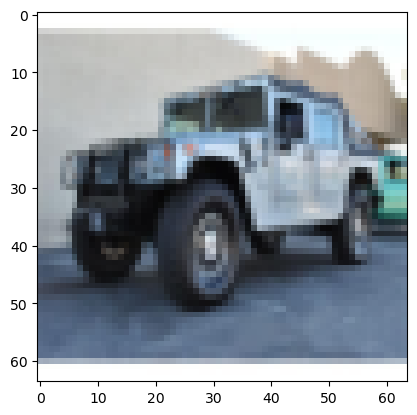

In [187]:
def show_image(img, label):
    img = (img + 1)/2
    print('Label: ', train_dataset.classes[label],  "(" + str(label) +")")
    plt.imshow(img.permute(1, 2, 0))

show_image(train_dataset[0][0], train_dataset[0][1])

# Note that the correct image shape should be height, width, channel
# but the original shape is channel, height, and width/ Therefore need to permute the shape of the tensor
# print(*train_dataset)

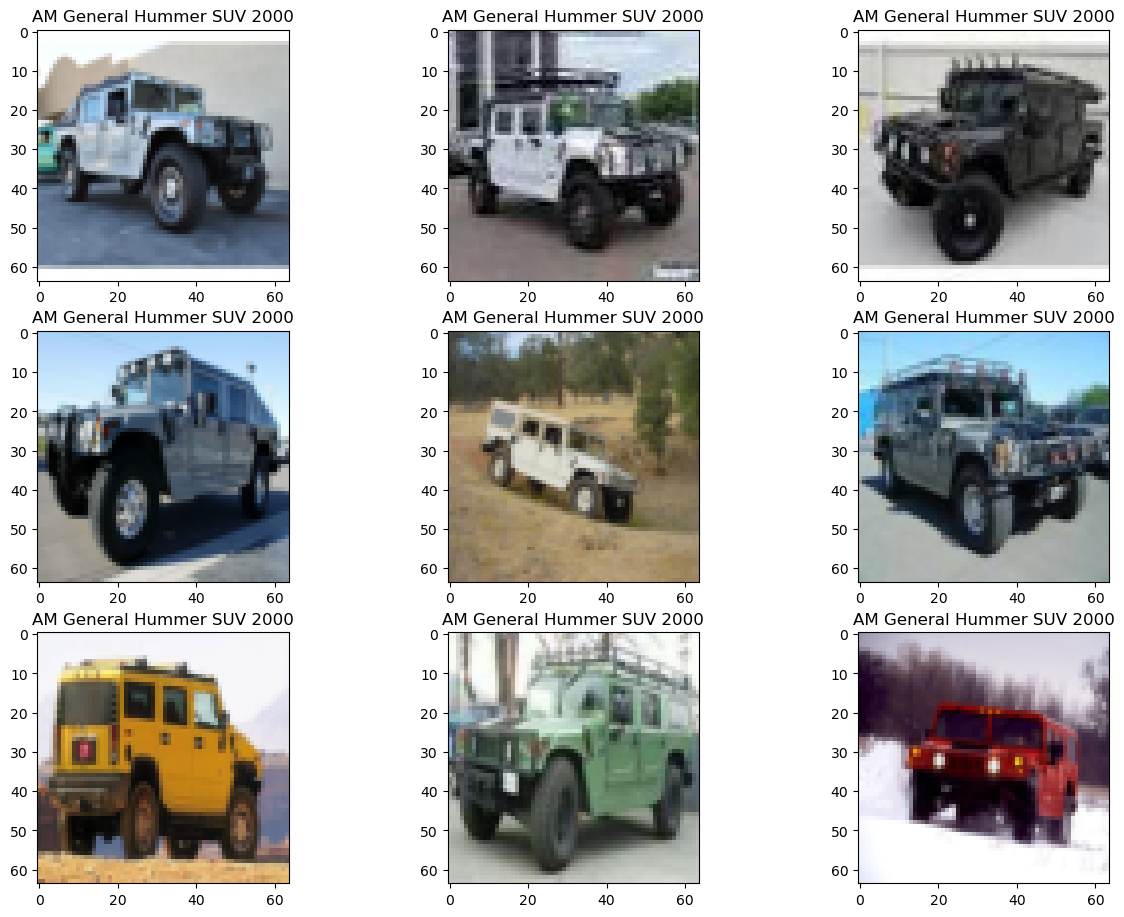

In [188]:
def show_images(dataset, num_samples=9, cols=3):
    """ Plots some samples from the dataset"""
    plt.figure(figsize = (15, 15))
    for i, data in enumerate(dataset):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols + 1), int(cols), i+1)
        img = (data[0]+1)/2
        plt.imshow(img.permute(1,2,0))
        plt.title(dataset.classes[data[1]])

show_images(train_dataset)

# A Diffusion Model from Scratch in Pytorch
In this notebook I want to build a very simple (as few code as possible) Diffusion Model for generating car images. I will explain all the theoretical details in the YouTube video. 


**Sources:**
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Niels Rogge, Kashif Rasul, [Huggingface notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/annotated_diffusion.ipynb#scrollTo=3a159023)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)

# Steps
- Forward process = Noise scheduler
- Backward process = U-Net
- The loss
- Sampling

# Forward process

In [189]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start = 0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    returns a specific index t of a passed list of values vals while considering the batch dimensions
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) *(len(x_shape)-1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestamp as input and returns the nosiy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)
    # return sqrt_one_minus_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)
    
# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis = 0)
print(alphas_cumprod)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value = 1.0)
print(alphas_cumprod_prev)
sqrt_recip_alphas = torch.sqrt(1.0/alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

tensor([0.9999, 0.9997, 0.9995, 0.9992, 0.9988, 0.9984, 0.9979, 0.9973, 0.9967,
        0.9960, 0.9952, 0.9944, 0.9935, 0.9926, 0.9915, 0.9905, 0.9893, 0.9881,
        0.9868, 0.9855, 0.9840, 0.9826, 0.9810, 0.9794, 0.9778, 0.9760, 0.9743,
        0.9724, 0.9705, 0.9685, 0.9665, 0.9644, 0.9623, 0.9601, 0.9578, 0.9555,
        0.9531, 0.9506, 0.9481, 0.9456, 0.9430, 0.9403, 0.9376, 0.9348, 0.9320,
        0.9291, 0.9261, 0.9232, 0.9201, 0.9170, 0.9139, 0.9107, 0.9074, 0.9041,
        0.9008, 0.8974, 0.8940, 0.8905, 0.8870, 0.8834, 0.8798, 0.8761, 0.8724,
        0.8687, 0.8649, 0.8611, 0.8572, 0.8533, 0.8493, 0.8454, 0.8413, 0.8373,
        0.8332, 0.8290, 0.8249, 0.8207, 0.8164, 0.8122, 0.8079, 0.8036, 0.7992,
        0.7948, 0.7904, 0.7859, 0.7815, 0.7770, 0.7725, 0.7679, 0.7633, 0.7587,
        0.7541, 0.7495, 0.7448, 0.7401, 0.7354, 0.7307, 0.7259, 0.7212, 0.7164,
        0.7116, 0.7068, 0.7020, 0.6972, 0.6923, 0.6874, 0.6826, 0.6777, 0.6728,
        0.6679, 0.6630, 0.6581, 0.6531, 

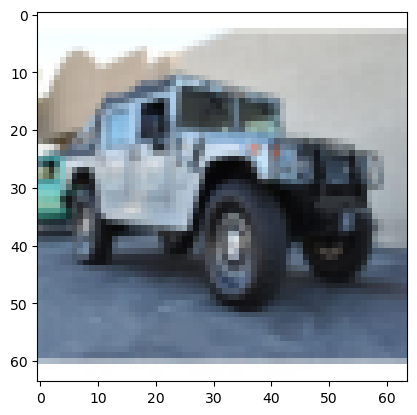

In [190]:
BATCH_SIZE = 128
    
def load_transformed_dataset(train_data, test_data):
    return torch.utils.data.ConcatDataset([train_data, test_data])

def show_tensor_image(image):
    reverse_transforms = tt.Compose(
        [
            transforms.Lambda(lambda t: (t+1) / 2),
            transforms.Lambda(lambda t: t.permute(1,2,0)),
            transforms.Lambda(lambda t: t*255),
            transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
            transforms.ToPILImage(),
        ]
    )
    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    image = image.clone()
    plt.imshow(reverse_transforms(image))

dataset = load_transformed_dataset(train_dataset, test_dataset)
show_tensor_image(dataset[0][0])
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

torch.Size([128, 3, 64, 64])
tensor([0])
tensor([30])
tensor([60])
tensor([90])
tensor([120])
tensor([150])
tensor([180])
tensor([210])
tensor([240])
tensor([270])


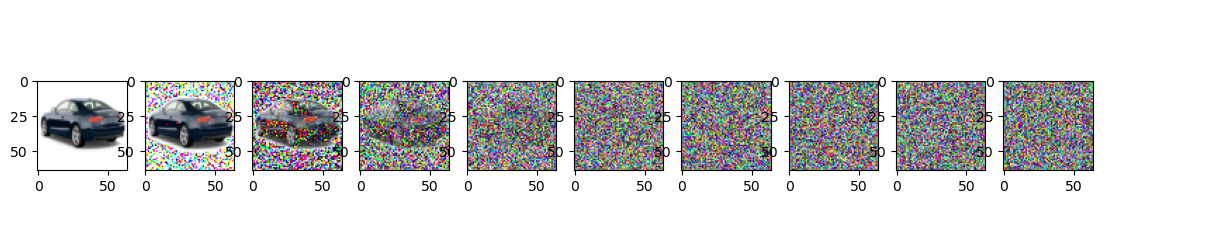

In [191]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]
# image = dataset[100][0]
print(image.shape)

plt.figure(figsize=(15,3))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    print(t)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    show_tensor_image(image)
    image, noise = forward_diffusion_sample(image, t)
    # show_tensor_image(image)

# Backward Process: U-Net

In [202]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.pool = nn.MaxPool2d(3, stride = 2)
        self.bnorm = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t,):
        # First conv
        h = self.bnorm(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(...,) + (None, )*2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)
        
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings    

class SimpleUnet(nn.Module):
    """
    A simplied variant of the unet architecture
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim), # linear layer: 32 to 32
            nn.ReLU() # add non-linearity
        )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels)-1)])

        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62433123


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (bnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2

# Loss function

* Use simple L1 loss-function
* There are other possible loss-function like L2 loss

In [203]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

# Sampling
- use no_grad() to reduce memory usage
- use pre-calculated noise variance to perform backward process

In [206]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns the denoised image
    Applies noise to this image, if we are not in the last step yet
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    #sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())

    plt.show()

# Training

Epoch 0 | step 000 Loss: 0.7550692558288574


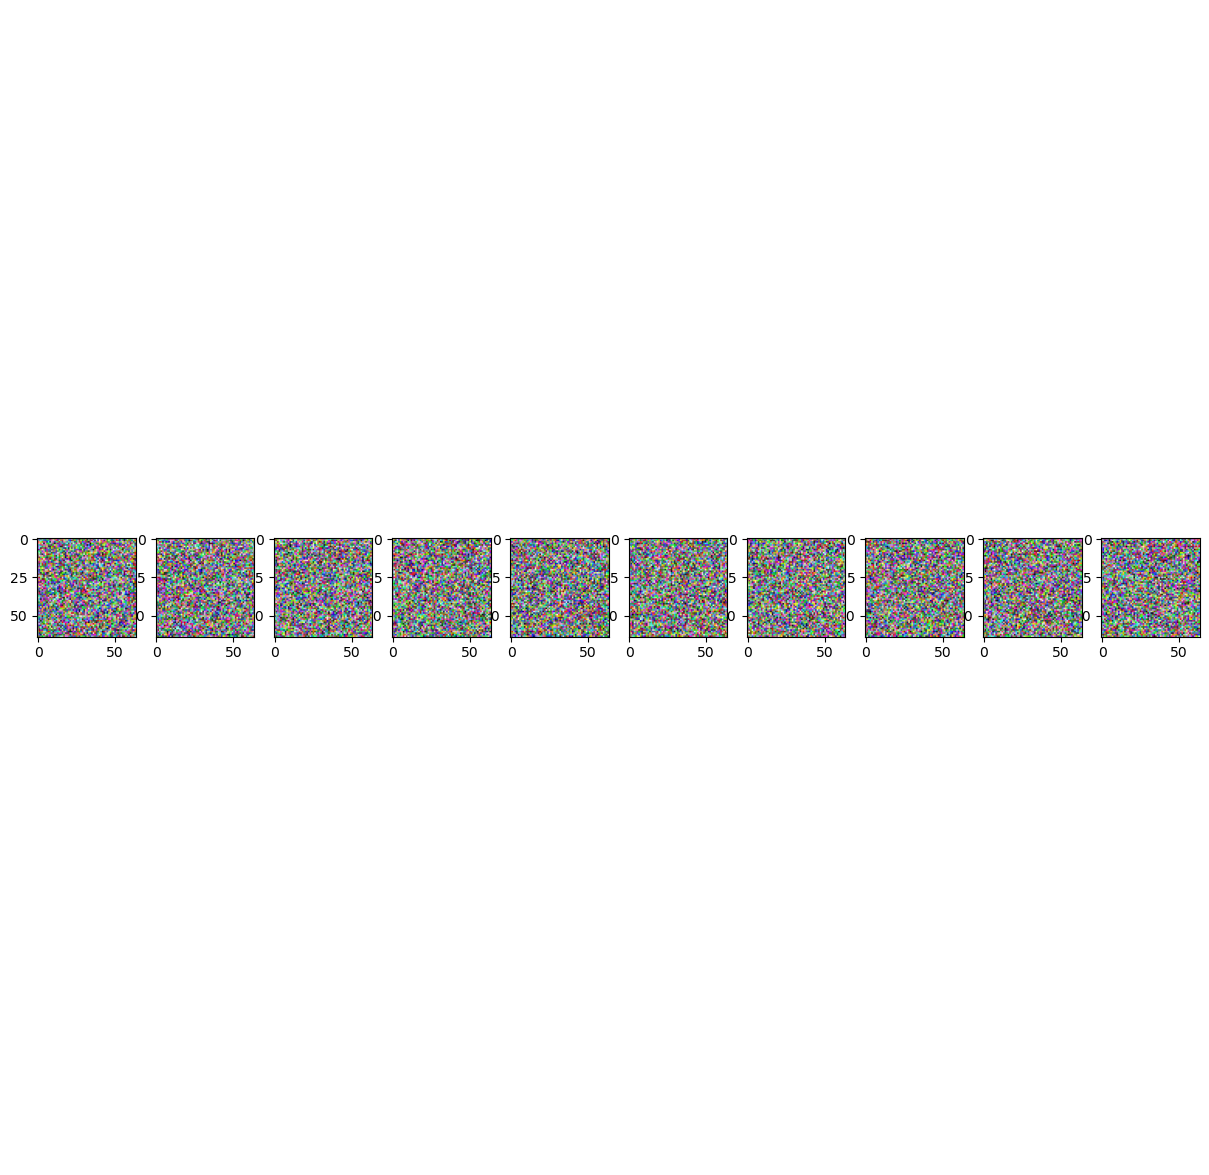


KeyboardInterrupt



In [207]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "mps"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 #Try more

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model, batch[0], t)
        loss.backward()
        optimizer.step()

        if epoch % 5 == 0 and step == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()}")
            sample_plot_image()

torch.Size([3, 60, 100])


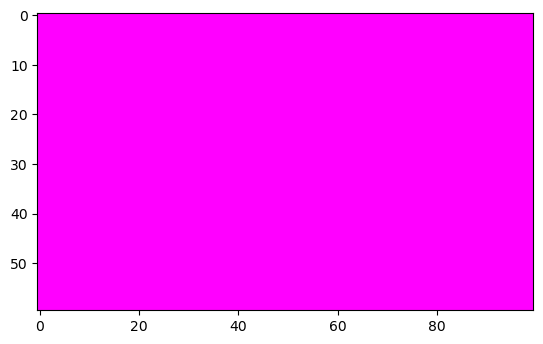

In [119]:
temp0 = np.ones((60, 100))*1 # red
temp1 = np.ones((60, 100))*0 # green
temp2 = np.ones((60, 100))*1 # blue
temp = np.stack([temp0, temp1, temp2])
torch_img = torch.from_numpy(temp)
print(torch_img.shape)
plt.imshow(torch_img.permute(1,2,0))

In [100]:
torch.randn_like(torch_img)

tensor([[[-0.0439,  0.0735, -0.9048,  ..., -1.0042, -0.7764, -0.4116],
         [-0.3595,  0.4998,  1.1880,  ...,  1.7876, -1.6671, -0.7063],
         [ 0.1626, -1.1896,  1.8017,  ..., -1.4916,  0.0561, -0.8443],
         ...,
         [-0.5510, -0.2507, -1.0866,  ..., -1.3816,  0.0334,  0.4960],
         [-1.3815, -1.0152, -0.3160,  ...,  1.0161, -0.7053,  0.4590],
         [-0.7996,  1.6372, -0.8465,  ...,  1.6933, -1.7555, -0.1180]],

        [[ 0.9060, -0.3033, -1.2390,  ...,  0.6724, -0.3462, -0.4349],
         [ 0.0226, -0.6024, -0.2793,  ...,  0.2420,  0.4388, -1.1537],
         [ 0.4852,  1.8569, -0.4394,  ..., -0.8928,  0.0312,  0.0755],
         ...,
         [-0.9477, -0.7022,  1.2514,  ...,  1.2712, -0.5603,  2.1835],
         [-0.1667, -0.4361, -0.4480,  ..., -0.5467,  0.0929, -0.2844],
         [ 0.6754, -0.7172,  0.5137,  ..., -0.5846, -0.7499,  0.5388]],

        [[-0.3499, -0.7000,  0.8871,  ..., -1.0984,  1.0280, -0.2157],
         [-1.7481, -0.3115,  0.5775,  ..., -0

In [126]:
for i, item in enumerate(dataloader):
    print(i)
    # print(item)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125


In [ ]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.pool = nn.MaxPool2d(3, stride = 2)
        self.bnorm = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

Block(64, 128, 32)

In [131]:
5%2

1

In [208]:
math.log(10000) / (16 - 1)

0.6140226914650789

In [214]:
time = [10]
device = 'mps'
half_dim = 32 // 2
embeddings = math.log(10000) / (half_dim - 1)
embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
embeddings = time[:, None] * embeddings[None, :]
# embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
embeddings

TypeError: list indices must be integers or slices, not tuple